# Question 2


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 640x640 1 person, 479.4ms
Speed: 3.5ms preprocess, 479.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 bounding boxes.
Bounding Box Coordinates: (-17007, -65415, 253127, 324788)


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Epoch [10/100], Loss: 1.2612
Epoch [20/100], Loss: 0.8305
Epoch [30/100], Loss: 0.6296
Epoch [40/100], Loss: 0.4957
Epoch [50/100], Loss: 0.4105
Epoch [60/100], Loss: 0.3515
Epoch [70/100], Loss: 0.3059
Epoch [80/100], Loss: 0.2690
Epoch [90/100], Loss: 0.2383
Epoch [100/100], Loss: 0.2123


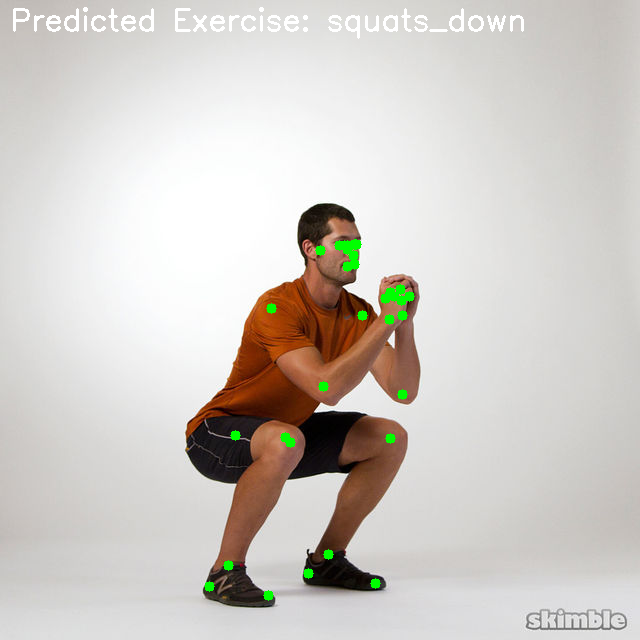

In [ ]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from mediapipe import solutions as mp_solutions
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Image Acquisition
def acquire_image(image_path):
    return cv2.imread(image_path)

# Step 2: Bounding Box Detection Using YOLO
def detect_person(image):
    model = YOLO('yolov5s.pt')  # Load YOLOv5s model
    results = model(image)      # Perform detection
    boxes = results[0].boxes.data.cpu().numpy()  # Extract boxes data
    return image, boxes

def get_bbox_from_yolo_box(box, image_width, image_height):
    """Converts YOLO box (center_x, center_y, width, height) to pixel coordinates (x1, y1, x2, y2)."""
    x_center, y_center, width, height = box[:4]

    # Convert normalized coordinates to pixel values
    x1 = int((x_center - width / 2) * image_width)
    y1 = int((y_center - height / 2) * image_height)
    x2 = int((x_center + width / 2) * image_width)
    y2 = int((y_center + height / 2) * image_height)

    return x1, y1, x2, y2

# Step 3: 3D Pose Estimation Using MediaPipe
def estimate_pose(image, bbox):
    mp_pose = mp_solutions.pose
    pose_estimator = mp_pose.Pose(static_image_mode=True, model_complexity=2)

    x1, y1, x2, y2 = bbox
    cropped_image = image[y1:y2, x1:x2]
    results = pose_estimator.process(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

    if results.pose_landmarks:
        return [(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]
    return []

# Step 4: Visualize Predicted Landmarks and Label
def visualize_predictions(original_image, landmarks_3d, predicted_label, bbox):
    vis_image = original_image.copy()
    x1, y1, x2, y2 = bbox
    cv2.rectangle(vis_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw bounding box

    for x, y, z in landmarks_3d:
        x_pixel = int(x * original_image.shape[1])
        y_pixel = int(y * original_image.shape[0])
        cv2.circle(vis_image, (x_pixel, y_pixel), 5, (0, 255, 0), -1)  # Draw landmarks

    cv2.putText(vis_image, f'Predicted Exercise: {predicted_label}', (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2_imshow(vis_image)

# Step 5: Custom CNN for Exercise Classification
class CustomCNN(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

# Function to classify exercise based on 3D landmarks
def classify_exercise(landmarks_3d, model, label_encoder):
    if not landmarks_3d:
        return "No landmarks detected."

    landmarks_array = np.array(landmarks_3d).flatten()
    expected_size = 115
    padded_array = np.pad(landmarks_array, (0, max(0, expected_size - len(landmarks_array))), 'constant')

    landmarks_tensor = torch.tensor(padded_array, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        output = model(landmarks_tensor)
        predicted = torch.argmax(output, dim=1).item()

    return label_encoder.inverse_transform([predicted])[0]

# Step 6: Prepare data and train the model
def prepare_data():
    
    data_paths = {
        "distances": '/content/drive/MyDrive/A2_DATA_q2/3d_distances.csv',
        "landmarks": '/content/drive/MyDrive/A2_DATA_q2/landmarks.csv',
        "labels": '/content/drive/MyDrive/A2_DATA_q2/labels.csv'
    }
    distances_3d_df = pd.read_csv(data_paths["distances"])
    landmarks_df = pd.read_csv(data_paths["landmarks"])
    labels_df = pd.read_csv(data_paths["labels"])

    merged_df = distances_3d_df.merge(labels_df, on='pose_id').merge(landmarks_df, on='pose_id')
    X = merged_df.drop(columns=['pose_id', 'pose'])
    y = merged_df['pose']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return train_test_split(X.values, y_encoded, test_size=0.2, random_state=42), label_encoder

def train_model(X_train, y_train):
    input_size = X_train.shape[1]
    num_classes = len(np.unique(y_train))

    model = CustomCNN(input_size, num_classes)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model


if __name__ == "__main__":
    image_path = '/content/drive/MyDrive/skimble-workout-trainer-exercise-squat-2_iphone.jpg'
    image = acquire_image(image_path)

    image_with_boxes, boxes = detect_person(image)
    if boxes.size > 0:
        image_height, image_width = image.shape[:2]
        bbox = get_bbox_from_yolo_box(boxes[0], image_width, image_height)
        landmarks_3d = estimate_pose(image, bbox)

        (X_train, X_test, y_train, y_test), label_encoder = prepare_data()
        model = train_model(X_train, y_train)

        predicted_label = classify_exercise(landmarks_3d, model, label_encoder)
        visualize_predictions(image, landmarks_3d, predicted_label, bbox)
    else:
        print("No bounding boxes detected.")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
